In [1]:
# imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import defaultdict

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# calculate du^ n / dt^n for arbitrary n and use this to create a loss term
def compute_derivative(u, t, norm_term, num_u_vectors):
    
    # compute derivative of outputs with respect to inputs 
    derivs_list = []
    for i in range(num_u_vectors):
        # individually compute du/dt for each u and combine them all togteher afterwards
        du_dt = torch.autograd.grad(u[:, i, :], t, grad_outputs=torch.ones_like(u[:, i, :]), create_graph=True)[0]
        derivs_list.append(du_dt)

    deriv_to_t = torch.stack(derivs_list, dim=1) 
    
    return deriv_to_t

# build the loss function
def loss(x, A, v, model):
    
    # loss results
    loss_dict = {}
            
    # create the trial solution
    model_result = lambda t: model(t)[0]
    u = model_result(x).unsqueeze(dim=-1)
    
    # determine the number of u vectors
    num_u_vectors = u.shape[1]
        
    # compute A * u
    A_times_u = torch.matmul(A, u)
    
    # compute du/dt (Note: each u is computed separately to avoid torch.autograd.grad() summing them together)
    du_dt = compute_derivative(u, x, 0, num_u_vectors)
    # du_dt = torch.autograd.functional.jacobian(model_result, x, create_graph=True).sum(axis=2) 

    # compute the L_T term
    L_t_term = du_dt + A_times_u
    L_t = torch.matmul(L_t_term.mT, L_t_term)
    
    # compute the L_0 term
    u_0 = model_result(torch.tensor([[0]], dtype=torch.float32))[0].unsqueeze(dim=-1)
    L_0_term = u_0 - v
    L_0 = torch.matmul(L_0_term.T, L_0_term)
    
    # compute the overall loss 
    L = torch.mean(L_t) + L_0
    
    # normalize loss and use it to compute the normalization factor
    # norm_term1, norm_term2 = 1 / As[0] ** 2, 1 / As[1] ** 2 ---> these are now 1 / v[0] **2 (I.C.)
    
    loss_dict['L_D'] = L
    loss_dict['L_total'] = L

    return loss_dict


In [3]:
# class to build the network 
class BuildNetwork(nn.Module):
    def __init__(self, input_size, h_size1, h_size2, h_size3, output_size):
        super(BuildNetwork, self).__init__()
        self.l1 = nn.Linear(input_size, h_size1)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(h_size1, h_size2)
        self.l3 = nn.Linear(h_size2, h_size3)
        self.output = nn.Linear(h_size3, output_size)
        
    def forward(self, x):
        result = self.l1(x)
        result = self.tanh(result)
        result = self.l2(result)
        result = self.tanh(result)
        result = self.l3(result)
        h = self.tanh(result)
        result = self.output(h)
        
        return result, h

In [4]:
# train and evaluate the model
def run_model(iterations, x_range, A, v, hid_lay, num_equations, true_functs):
        
    assert num_equations > 0, 'The number of equations must be >= 1'
    
    # build the neural net model
    model = BuildNetwork(1, hid_lay[0], hid_lay[1], hid_lay[2], num_equations)
    # set-up the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    # create a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # extract the min and max range of x values to sample
    min_x, max_x = x_range
    
    # create a random number generator for loss computation
    rng = np.random.default_rng()
    
    # store loss and mse values
    loss_history = defaultdict(list)
    MSEs = []
    
    start_time = time.time()
#     curr_A_indx = -1 NOTE: commented out until we do transfer learning
    
    for i in range(iterations):
        
        if i % 2000 == 0: 
#             curr_A_indx += 1 NOTE: commented out until we do transfer learning
#             A = A_vals[curr_A_indx] NOTE: commented out until we do transfer learning
            print(f"Iteration {i + 1} starting")
        
        # every batch, randomly sample from min and max range
        x = torch.arange(min_x, max_x, 0.001, requires_grad=True)
        x = x[rng.integers(low=0, high=len(x), size=500)]
        x = x.reshape(-1, 1)

        # forward: compute loss
        curr_loss = loss(x, A, v, model)
        
        # store individual loss terms for plotting
        loss_history['LD_losses'].append(curr_loss['L_D'].item())
        loss_history['Ltotal_losses'].append(curr_loss['L_total'].item())
            
        # backward: backpropagation
        curr_loss['L_total'].backward()
        
        # update weights and reset the gradients
        optimizer.step() 
        optimizer.zero_grad() 
        
        # learning rate update
        # scheduler.step()
        
        # compute the mse
        with torch.no_grad():
            current_mse = 0
            for i in range(num_equations):
                network_sol_i = model(x)[0][:, i].unsqueeze(dim=1).numpy()
                true_sol_i = true_functs[i](x)
                current_mse += np.mean((true_sol_i - network_sol_i) ** 2)
            MSEs.append(current_mse)
               
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"Model Training Complete in{total_time: .3f} seconds")
    
    return loss_history, model, total_time, MSEs

In [5]:
# function to plot the neural network vs exact solution
def plot_solution(x_range, true_functs, trained_model, axis):
    
    # function to extract the model results
    model_result = lambda t: trained_model(t)[0]
    
    # x values to predict on
    min_x, max_x = x_range
    xx = np.linspace(min_x, max_x, 200)[:, None]

    # find the model results
    u = model_result(torch.Tensor(xx))
    # determine the number of curves to plot
    num_curves = u.shape[1]
    # store the true solutions and network solutions
    yys, yts = [], []

    # save the network solutions in a list for plotting 
    with torch.no_grad():
        for i in range(num_curves):
            yys.append(u[:, i].numpy())
            yts.append(true_functs[i](xx))
    
    # plot the true solutions
    for i in range(num_curves):
         axis.plot(xx, yts[i], label=f'Actual Solution $u_{i+1}(t)$')
     
    # plot the network solutions
    for i in range(num_curves):
        axis.plot(xx, yys[i], '--', label=f'Neural Network Solution $u_{i+1}(t)$')
            
    axis.set_title("u(t) vs t for Actual and Approximation")
    axis.set_xlabel('$t$')
    axis.set_ylabel('$u(t)$')
    axis.legend(loc='best')
    
# function to plot the overall loss of the network solution
def plot_total_loss(iterations, train_losses, axis, loss_label):
    axis.plot(range(iterations), train_losses, label=loss_label)
    axis.set_yscale("log")
    axis.set_title("Total Loss vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('Loss')
    axis.legend(loc='best')
    
# function to plot the MSEs
def plot_mse(iterations, mses, axis):
    axis.plot(range(iterations), mses, label='MSE')
    axis.set_yscale("log")
    axis.set_title("MSE vs Iterations")
    axis.set_xlabel('Iterations')
    axis.set_ylabel('MSE')
    axis.legend(loc='best')
    
# wrapper function to plot the solution and the overall loss & MSE of the network solution
def plot_loss_mse_and_solution(x_range, true_functs, iterations, trained_model, train_losses, 
                               loss_label, mses):
    
    fig, axs = plt.subplots(1, 3,  tight_layout=True, figsize=(24, 8))
    
    plot_total_loss(iterations=iterations, train_losses=train_losses, 
                    axis=axs[0], loss_label=loss_label)
    plot_solution(x_range=x_range, true_functs=true_functs, 
                  trained_model=trained_model, axis=axs[1])
    plot_mse(iterations=iterations, mses=mses, axis=axs[2])
    
    plt.show()

In [6]:
# set-up differential equation parameters for network
x_range = [0, 2]
A = torch.tensor([[0, 1.1], [1.1, 0]])
v = torch.tensor([[0.75], [0.25]])
hid_lay = [64, 64, 128]
num_equations, iterations = 2, 10000

# write actual solutions for computing MSE and plotting true solution
true_f1 = lambda x: (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
true_f2 = lambda x: (0.5 * v[1] * np.exp(-1.1 * x) * (np.exp(2.2 * x) + 1) - (0.5 * v[0] * np.exp(-1.1 * x) * (np.exp(2.2 * x) - 1))).numpy()
true_functs = [true_f1, true_f2]


Iteration 1 starting
Iteration 2001 starting
Iteration 4001 starting
Iteration 6001 starting
Iteration 8001 starting
Model Training Complete in 44.038 seconds


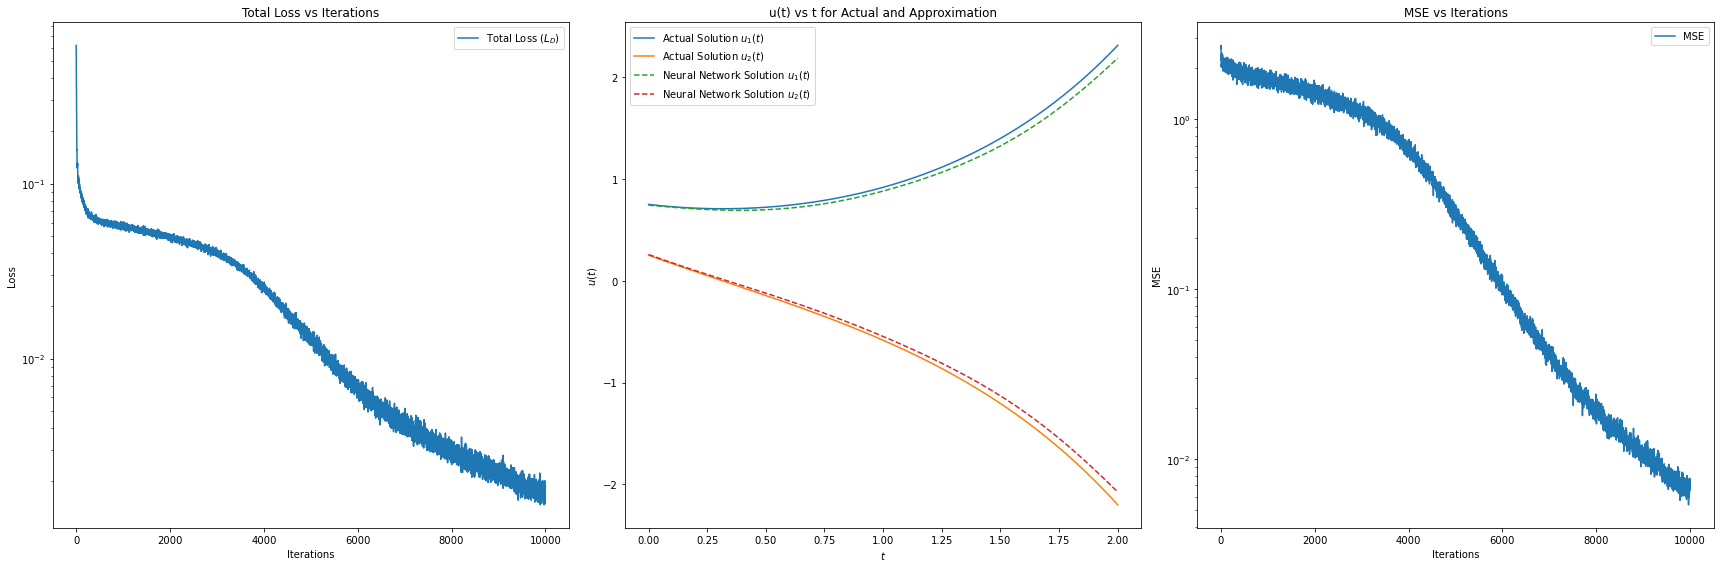

In [7]:
# run model which has a loss of the MSE (i.e. no higher order terms)
loss_history_w1, trained_model_w1, time_w1, MSE_w1 = run_model(iterations=iterations, x_range=x_range, 
                                                               A=A, v=v, hid_lay=hid_lay,
                                                               num_equations=num_equations, 
                                                               true_functs=true_functs)

# plot the total loss, network vs true solution, and MSE
plot_loss_mse_and_solution(x_range=x_range, true_functs=true_functs, iterations=iterations, 
                           trained_model=trained_model_w1, 
                           train_losses=loss_history_w1['Ltotal_losses'], 
                           loss_label='Total Loss ($L_D$)', mses=MSE_w1)

In [8]:
# # create a t to take derivative with respect to 
# rng = np.random.default_rng()
# t_eval = torch.arange(0, 2, 0.001, requires_grad=True)
# t_eval = t_eval[rng.integers(low=0, high=2000, size=500)]
# t_eval = t_eval.reshape(-1, 1)

# # forward pass to extract H 
# output, H = trained_model_w1(t_eval) 

# print("H shape before column of 1s: ", H.shape)
# H = torch.cat((torch.ones(len(t_eval), 1), H), 1)
# print("H shape after column of 1s: ", H.shape)

# # compute derivative w/r/t H and multiply it by its transpose
# dH_dt = torch.autograd.functional.jacobian(trained_model_w1 ,t_eval, create_graph=True)[1].sum(axis=2)

# print("dh_dt before adjusting: ", dH_dt.shape)
# dH_dt = torch.cat((torch.zeros(len(t_eval), 1, 1), dH_dt), 1)
# print("dh_dt after adjusting: ", dH_dt.shape)

In [9]:
# # compute dH_dt times dH_dt transpose 
# dH_dt_times_dH_dt_T = torch.matmul(dH_dt, dH_dt.mT)
# print("dH_dt * dH_dt_T: ", dH_dt_times_dH_dt_T.shape)

# # compute dH_dt times H transpose 
# new_H = torch.unsqueeze(H, dim=-1)
# dH_dt_times_H_T = torch.matmul(dH_dt, new_H.mT)
# print("dH_dt * H_T: ", dH_dt_times_H_T.shape)

# # compute H times dH_dt transpose
# H_times_dH_dt_T = torch.matmul(new_H, dH_dt.mT)

# # compute H times H transpose
# H_times_H_T = torch.matmul(new_H, new_H.mT)
# print("H * H_T: ", H_times_H_T.shape)

# # compute the sum of matrices across time
# # w_sum_term = dH_dt_times_dH_dt_T + 2 * lambda_val * dH_dt_times_H_T + lambda_val ** 2 * H_times_H_T
# w_sum_term = dH_dt_times_dH_dt_T + lambda_val * dH_dt_times_H_T + lambda_val * H_times_dH_dt_T + lambda_val ** 2 * H_times_H_T 

# print("W_sum shape before summing across time: ", w_sum_term.shape)
# w_sum_term = w_sum_term.sum(axis=0)
# w_sum_term = w_sum_term / len(t_eval)
# print("W_sum shape after summing across time: ", w_sum_term.shape)

# # compute H_0 and multiply it by its transpose 
# output_0, H_0 = trained_model_w1(torch.tensor([[0.]], dtype=torch.float32, requires_grad=True))
# print("H_0 shape before appending 1: ", H_0.shape)
# H_0 = torch.cat((torch.ones(1, 1), H_0), 1)
# print("H_0 shape after appending 1: ", H_0.shape)

# H_0_T_times_H_0 = torch.matmul(H_0.T, H_0)
# print("H_0_T * H_0 shape: ", H_0_T_times_H_0.shape)

In [10]:
# # build the M matrix and find its inverse 
# M = w_sum_term + H_0_T_times_H_0
# M_inverse = torch.linalg.pinv(M)

# # compute W_out
# w_out = torch.matmul(M_inverse, H_0.T) * 0.75

In [11]:
# tranfer_learned = [torch.matmul(w_out.T, new_H[i]).item() for i in range(500)]
# times = list(t_eval.detach().numpy().squeeze())

# true = [0.75 * np.exp(-lambda_val * time) for time in times]
# plt.scatter(times, tranfer_learned, label = 'Transfer Learning')
# plt.scatter(times, true, label='Analytical', s=10)
# plt.xlabel("t")
# plt.ylabel('y')
# plt.title("Transfer Learning vs Analytical Solution")
# plt.legend();

In [12]:
# start_one_shot_time = time.time()
# rng = np.random.default_rng(12345)
# for i in range(10000):
#     random_u_0 = rng.random()
#     w_out = torch.matmul(M_inverse, H_0.T) * random_u_0
    
# end_one_shot_time = time.time() 
# total_one_shot = end_one_shot_time - start_one_shot_time
# print(f"Total Time to evaluate w_out for 10000 different initial conditions: {total_one_shot: .2f} seconds")

In [13]:
# residuals = (torch.matmul(w_out.T, dH_dt[:]) + lambda_val * torch.matmul(w_out.T, new_H[:])) ** 2
# residuals = residuals.reshape(500, 1).detach().numpy()

# print(f"Mean of residuals: {residuals.mean()}")
# initial_cond_residuals = (torch.matmul(w_out.T, H_0.T) - 0.75) ** 2
# print(f"Initial Condition Residual: {initial_cond_residuals.item()}")

# plt.plot(residuals);
# plt.xlabel("t")
# plt.ylabel("Residual")
# plt.title("Plot of Residuals");

In [14]:
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[0]: .3f}: {(0.75 * np.exp(-lambda_val * times[0]) - torch.matmul(w_out.T, H[0])).item(): .5f}")
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[100]: .3f}: {(0.75 * np.exp(-lambda_val * times[100]) - torch.matmul(w_out.T, H[100])).item(): .5f}")
# print(f"Difference Between Analytical and Tranfer Learned for t ={times[200]: .3f}: {(0.75 * np.exp(-lambda_val * times[200]) - torch.matmul(w_out.T, H[200])).item(): .5f}")

In [15]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# H_test = H.detach()
# gm_H = torch.matmul(H_test.T, H_test)
# pca = PCA(n_components=5)
# pca.fit(gm_H)
# print(pca.explained_variance_ratio_)

In [16]:
# TODO:

# 1. figure out how the torch.autograd.grad is working with du/dt

# 2. compute the individual terms needed in the w_out calculation for a system

# 3. add the higher order terms, L_D and L_DD, etc?

# 4. figure out how to add the the norm term in the loss function

# 5. see which parts of the formula are dependent on time and ask Pavlos how that works
    # (changing W_o means that only u_o will change eventually?)

# 6. try using a different diff. equation

# 7. make loss function proper

# Appendix

### Notes:

- $u_t = lambda$ $t: A + t * model(t)$ is outdated, so we use $ u_t = lambda$ $t: A + (1 - exp(-t)) * model(t)$

- We are solving $\frac{du}{dt} + \lambda * u = 0$ where $f = -\lambda * u$

- Old Model Code: model = nn.Sequential(nn.Linear(1, 64), nn.Tanh(), nn.Linear(64, 64), nn.Tanh(), nn.Linear(64,1))

- Old solution parametrization: u_t = lambda t: A + (1 - torch.exp(-t)) * model(t)

- Original normalization term: norm_term = 1 / u_t(torch.tensor([[0]], dtype=torch.float32)) ** 2